In [26]:
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

%matplotlib inline
import mplleaflet
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.pylab as pylab
import seaborn as sns

from geopy.distance import geodesic
import os
import warnings

warnings.simplefilter("ignore")
tqdm.pandas()

np.random.seed(3)

In [2]:
data_dir = '../data/'
quimio_name = 'Pulmão Quimioterapia SIA-SUS.csv'
radio_name = 'Pulmão Radioterapia SIA-SUS.csv'
municipios_name = 'dados_municipios.csv'
usecols_quimio = ['AP_VL_AP', 'AP_UFMUN', 'AP_NUIDADE', 'AP_SEXO', 'AP_RACACOR', 'AP_MUNPCN', 
               'AQ_ESTADI', 'AQ_DTIDEN', 'AQ_DTINTR']

usecols_radio = ['AP_VL_AP', 'AP_UFMUN', 'AP_NUIDADE', 'AP_SEXO', 'AP_RACACOR', 'AP_MUNPCN', 
               'AR_ESTADI', 'AR_DTIDEN', 'AR_DTINTR']

dtype_cols = {'AP_MUNPCN': str, 'AP_UFMUN': str}

codigo_uf = '23' #estado a ser analisado

In [3]:
def coord_from_codigo(codigo):
    '''
    Retorna a latitude e longitude
    '''
    try:
        return municipios.loc[codigo]['LATITUDE'], municipios.loc[codigo]['LONGITUDE']
    except:
        return 0, 0
    
def calculte_distance(row):
    '''
    Calcula a distância dado as coordenadas
    '''
    try:
        cidade_tratamento = row['AP_UFMUN']
        cidade_paciente = row['AP_MUNPCN']
        lat_cid_trat = municipios['LATITUDE'][str(cidade_tratamento)]
        long_cid_trat = municipios['LONGITUDE'][str(cidade_tratamento)]
        lat_cid_pac = municipios['LATITUDE'][str(cidade_paciente)]
        long_cid_pac =municipios['LONGITUDE'][str(cidade_paciente)]
        return geodesic((lat_cid_pac, long_cid_pac), (lat_cid_trat, long_cid_trat)).km
    except:
        # se o codigo do municipio não existir (e.g. por erro de digitação) então retorna NaN
        return np.nan

In [4]:
# Lendo os dataframes:

quimio = pd.read_csv(os.path.join(data_dir, quimio_name), encoding='latin', index_col=0, 
                     error_bad_lines=False, low_memory=False, usecols=usecols_quimio, dtype=dtype_cols)

radio = pd.read_csv(os.path.join(data_dir, radio_name), encoding='latin', index_col=0, 
                    error_bad_lines=False, low_memory=False, usecols=usecols_radio, dtype=dtype_cols)

municipios = pd.read_csv(os.path.join(data_dir, municipios_name), index_col=0, dtype={'COD_MUN': str})

In [5]:
# Removendo o último digito para se adequar ao dataframe das APACs:

municipios.index = municipios['COD_MUN'].apply(lambda x: x[:-1])

In [6]:
quimio['distância'] = quimio.progress_apply(calculte_distance, axis=1)

100%|██████████| 279825/279825 [00:58<00:00, 4770.61it/s]


Em primeira analisae, vamos analisar apenas os pacientes de quimioterapia que moram e se trataram no estado em questão.

In [7]:
bool_index = (quimio['AP_MUNPCN'].str.startswith(codigo_uf)) & (quimio['AP_UFMUN'].str.startswith(codigo_uf))
df_estado = quimio[bool_index].reset_index()

In [8]:
# Coordenadas da cidade tratamento:

df_estado['LAT_MUN'] = df_estado.apply(lambda row: municipios.loc[row['AP_UFMUN']]['LATITUDE'], axis=1)
df_estado['LON_MUN'] = df_estado.apply(lambda row: municipios.loc[row['AP_UFMUN']]['LONGITUDE'], axis=1)

In [9]:
# Coordenadas da cidade de residencia do paciente:

df_estado['LAT_PCN'] = df_estado.apply(lambda row: municipios.loc[row['AP_MUNPCN']]['LATITUDE'], axis=1)
df_estado['LON_PCN'] = df_estado.apply(lambda row: municipios.loc[row['AP_MUNPCN']]['LONGITUDE'], axis=1)

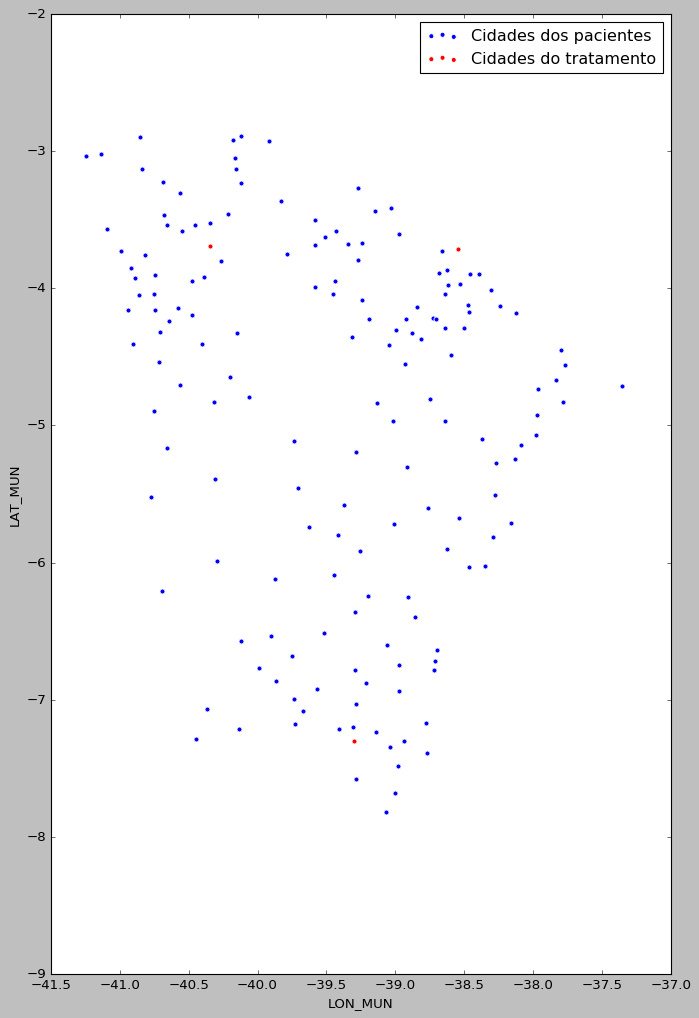

In [10]:
# Plotando onde os pacientes residem e onde foram atendidos para um estado qualquer:
plt.style.use('classic')
plt.figure(figsize=[10,15])
sns.scatterplot(data=df_estado, x='LON_PCN', y='LAT_PCN', color='b')
sns.scatterplot(data=df_estado, x='LON_MUN', y='LAT_MUN', color='r')
plt.legend(['Cidades dos pacientes', 'Cidades do tratamento'])
plt.show()

100%|██████████| 168/168 [00:00<00:00, 501.84it/s]


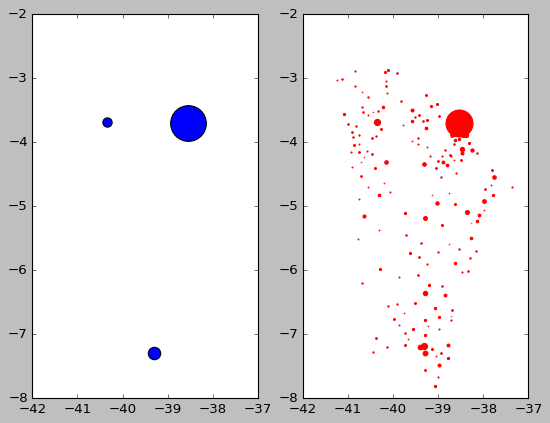

In [12]:
# Plotando o número de unidades que tratam cancêr e o número de pacientes

fig, axes = plt.subplots(1, 2)
muns = df_estado['AP_UFMUN'].unique()
muns2 = df_estado['AP_MUNPCN'].unique()
temp_df = df_estado['AP_UFMUN'].value_counts()
temp_df2 = df_estado['AP_MUNPCN'].value_counts()
for mun in muns:
    lat, long = coord_from_codigo(mun)
    if lat==0:
        continue
    axes[0].scatter(long, lat, s=temp_df.loc[mun]*1e-1)
 
   
for mun in tqdm(muns2):
    lat, long = coord_from_codigo(mun)
    if lat==0:
        continue
    axes[1].scatter(long, lat, s=temp_df2.loc[mun]*1e-1, color='r')
    
    
axes[1].set_ylim((-8, -2))
axes[1].set_xlim((-42, -37))
axes[0].set_ylim(plt.ylim())
axes[0].set_xlim(plt.xlim());

# Claramente, o número de locais capazes de tratar os pacientes é insuficiente para tratar toda a população do estado.

100%|██████████| 168/168 [00:00<00:00, 442.98it/s]


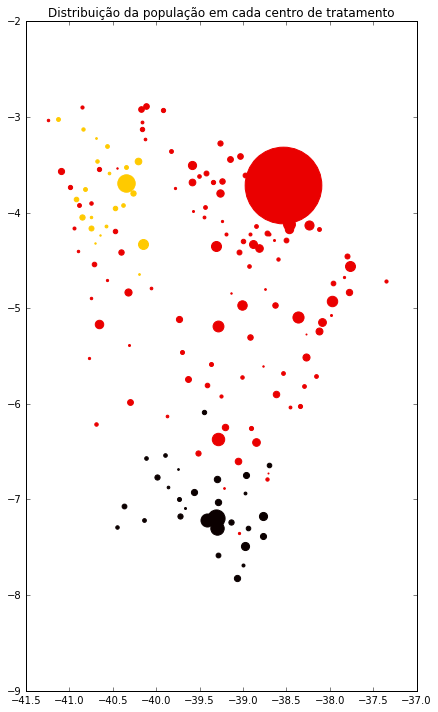

In [46]:
temp_df = pd.crosstab(index=df_estado['AP_MUNPCN'], columns=df_estado['AP_UFMUN'])
norm = mpl.colors.Normalize(vmin=0, vmax=len(temp_df.columns))
cmap = cm.hot
m = cm.ScalarMappable(norm=norm, cmap=cmap)
colors = {col: m.to_rgba(i) for i, col in enumerate(temp_df.columns)}
plt.figure(figsize=[7,12])
for mun in tqdm(temp_df.index):
    lat, long = coord_from_codigo(mun)
    if lat==0:
        continue
        
    plt.scatter(long, lat, s=temp_df2.loc[mun], color=colors[temp_df.loc[mun].argmax()])
    
plt.title("Distribuição da população em cada centro de tratamento");